<a href="https://colab.research.google.com/github/Ana-AlonsoCanizares/LHMProgram/blob/main/LMHSS23_AAI_Week1_Ex2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Can you generate faces?
##### We expect you to use images to generate new ones with a Generative Model of your choice. You have to write a dataloader to read images from the folder 'cropped/', write a Generative Model class, a loss function, a training loop, and visualize your generated images.

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import imageio as Image
from torchvision.utils import make_grid
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader

### Nothing to change here (This cell downloads and unzips the data).

In [ ]:
!wget https://www.dropbox.com/s/g0w7a3x1aw3oonf/SimpsonFaces.zip?dl=0

!unzip SimpsonFaces.zip?dl=0

!ls

Streaming output truncated to the last 5000 lines.
  inflating: __MACOSX/cropped/._4084.png  
  inflating: cropped/3933.png        
  inflating: __MACOSX/cropped/._3933.png  
  inflating: cropped/2393.png        
  inflating: __MACOSX/cropped/._2393.png  
  inflating: cropped/1842.png        
  inflating: __MACOSX/cropped/._1842.png  
  inflating: cropped/4912.png        
  inflating: __MACOSX/cropped/._4912.png  
  inflating: cropped/326.png         
  inflating: __MACOSX/cropped/._326.png  
  inflating: cropped/440.png         
  inflating: __MACOSX/cropped/._440.png  
  inflating: cropped/9588.png        
  inflating: __MACOSX/cropped/._9588.png  
  inflating: cropped/8696.png        
  inflating: __MACOSX/cropped/._8696.png  
  inflating: cropped/6863.png        
  inflating: __MACOSX/cropped/._6863.png  
  inflating: cropped/454.png         
  inflating: __MACOSX/cropped/._454.png  
  inflating: cropped/8682.png        
  inflating: __MACOSX/cropped/._8682.png  
  inflating: cropp

## Dataloader
####  Write a dataloader to read images from the folder 'cropped/' (Note that the transform *trans* resizes the images to 32x32)

In [ ]:
trans = transforms.Compose([transforms.ToTensor(),transforms.Resize([32,32])])

# Replace the question marks '?' by the necessary code
batch_size = 32

class MyDataset(Dataset):
  def __init__(self, image_path, transform = trans):
    self.image_path = image_path
    self.images = os.listdir(image_path)
    self.transform = transform

  def __len__(self):
    return len(self.images)

  def __getitem__(self,idx):
    im = Image.imread(f"{self.image_path}{self.images[idx]}")
    im = self.transform(im)
    return im

In [ ]:
dataset = MyDataset("cropped/")

train_loader = DataLoader(dataset, batch_size = batch_size)

#### Visualize the data
##### Get a batch from the dataloader and visualize its images

In [ ]:
# Generataor: 5 conv layer 1 linear layer
# Discriminator: 4 conv layers 1 linear layer

class Generator(nn.Module):
  def __init__(self, zdim):
    super().__init__()
    self.linear1 = nn.Linear(zdim, 1024*4*4)
    self.bn1 = nn.BatchNorm1d(1024*4*4)
    self.conv1 = nn.ConvTranspose2d(1024, 512, 5, 2, 2, output_padding = 1 )
    self.bn2 = nn.BatchNorm2d(512)
    self.conv2 = nn.ConvTranspose2d(512, 256, 5, 1, 2 )
    self.bn3 = nn.BatchNorm2d(256)
    self.conv3 = nn.ConvTranspose2d(256, 128, 5, 2, 2, output_padding = 1 )
    self.bn4 = nn.BatchNorm2d(128)
    self.conv4 = nn.ConvTranspose2d(128, 32, 5, 1, 2 )
    self.bn5 = nn.BatchNorm2d(32)
    self.conv5 = nn.ConvTranspose2d(32, 3, 5, 2, 2, output_padding = 1 )

  def forward(self, x):
    x = self.linear1(x)
    x = self.bn1(x)
    x = F.leaky_relu(x, 0.2)
    x = x.view(-1, 1024, 4, 4)
    x = self.conv1(x)
    x = self.bn2(x)
    x = F.leaky_relu(x, 0.2)

    x = self.conv2(x)
    x = self.bn3(x)
    x = F.leaky_relu(x, 0.2)

    x = self.conv3(x)
    x = self.bn4(x)
    x = F.leaky_relu(x, 0.2)


    x = self.conv4(x)
    x = self.bn5(x)
    x = F.leaky_relu(x, 0.2)

    x = self.conv5(x)
    x = F.tanh(x)
    return x


class Discriminator(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 64, 3, 1, 1)
    self.bn1 = nn.BatchNorm2d(64)
    self.conv2 = nn.Conv2d(64, 128, 3, 2, 1)
    self.bn2 = nn.BatchNorm2d(128)
    self.conv3 = nn.Conv2d(128, 256, 3, 2, 1)
    self.bn3 = nn.BatchNorm2d(256)
    self.conv4 = nn.Conv2d(256, 512, 3, 2, 1)
    self.bn4 = nn.BatchNorm2d(512)
    self.linear1 = nn.Linear(512*4*4, 1)


  def forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = F.leaky_relu(x, 0.2)

    x = self.conv2(x)
    x = self.bn2(x)
    x = F.leaky_relu(x, 0.2)

    x = self.conv3(x)
    x = self.bn3(x)
    x = F.leaky_relu(x, 0.2)

    x = self.conv4(x)
    x = self.bn4(x)
    x = F.leaky_relu(x, 0.2)

    x = x.view(-1, 512*4*4)

    x = self.linear1(x)
    x = F.sigmoid(x)
    return x




In [ ]:
def weights_init(m):
    """Reinitialize model weights. GAN authors recommend them to be sampled from N(0,0.2)"""
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
zdim = 100
device = torch.device("cuda:0")
generator = Generator(zdim)
generator.apply(weights_init)
generator.to(device)

discriminator = Discriminator()
discriminator.apply(weights_init)
discriminator.to(device)

Discriminator(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear1): Linear(in_features=8192, out_features=1, bias=True)
)

### Generative Model class
#### Write a Generative Model class in the following cell

<ipython-input-19-0a435ac68eed>:16: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im = Image.imread(f"{self.image_path}{self.images[idx]}")


KeyboardInterrupt: ignored

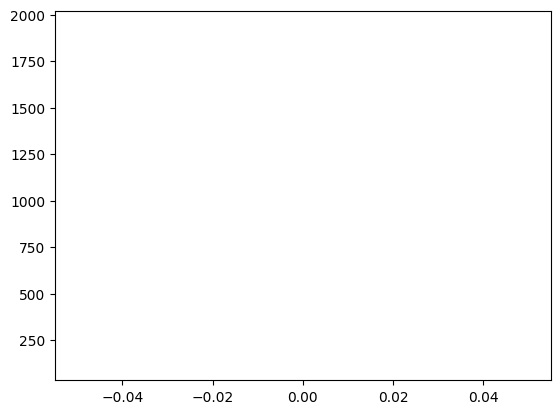

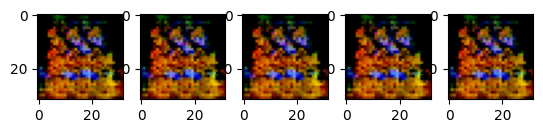

In [ ]:
opt_d = optim.Adam(discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999))
opt_g = optim.Adam(generator.parameters(), lr=2e-4, betas=(0.5, 0.999))

num_epochs = 40
ls_g = []
ls_d = []
for i in range(num_epochs):
  tl_g = 0
  tl_d = 0
  for batch in train_loader:
    X = batch.to(device)
    X = 2*X - 1
    #discriminator for correct images
    labels = torch.ones((X.shape[0], 1)).to(device)
    out = discriminator(X)
    loss = F.binary_cross_entropy(out, labels)
    opt_d.zero_grad()
    loss.backward()
    tl_d += loss.item()

    #discriminator for fake images
    noise = torch.randn(X.shape[0], zdim).to(device)
    Xf = generator(noise)
    labels = torch.zeros((Xf.shape[0],1)).to(device)
    out_f = discriminator(Xf)
    loss_f = F.binary_cross_entropy(out_f, labels)
    loss_f.backward()
    opt_d.step()
    tl_d += loss_f.item()

    #generator training
    noise = torch.randn(X.shape[0], zdim).to(device)
    Xf = generator(noise)
    labels_f = torch.ones((Xf.shape[0],1)).to(device)
    out_g = discriminator(Xf)
    loss_g = F.binary_cross_entropy(out_g, labels_f)
    opt_g.zero_grad()
    loss_g.backward()
    opt_g.step()
    tl_g += loss_g.item()

  ls_g.append(tl_g)
  ls_d.append(tl_d)
  if i%2==0:
    with torch.no_grad():
      plt.plot(ls_d)
      plt.plot(ls_g)
      plt.figure()
      for j in range(5):
        plt.subplot(1,5,j+1)
        plt.imshow(0.5*(Xf[i,:,:,:]+0.5).detach().cpu().numpy().transpose(1,2,0))
        plt.show

## Loss
#### Define Loss function in the following cell

In [ ]:
# ADD CODE HERE


### Training Loop
#### Define optimizer, write the training loop in the following cell, and plot the loss

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Update the question marks '?' and add code where needed
nz = ?
net = ?
num_epochs = ?
lr = ?
opt = ?

for i in range(num_epochs):
  for batch in train_loader:
    # ADD CODE HERE


## Generate and Plot Data
#### Generate a batch of 64 images and plot them in subplots of 8 rows and 8 columns.

In [ ]:
# ADD CODE HERE
